# Z:P ratio regridded!! So that we can compare with biomes! 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
from cartopy.util import add_cyclic_point

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [5]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [6]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [7]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [8]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

ds= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

### Import regridded Zooplankton Carbon

In [9]:
zoo1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo1C.*.nc', recursive=True))
zoo1_ds = xr.open_mfdataset(zoo1_inds,combine='by_coords')
zoo2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo2C.*.nc', recursive=True))
zoo2_ds = xr.open_mfdataset(zoo2_inds,combine='by_coords')
zoo3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo3C.*.nc', recursive=True))
zoo3_ds = xr.open_mfdataset(zoo3_inds,combine='by_coords')
zoo4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo4C.*.nc', recursive=True))
zoo4_ds = xr.open_mfdataset(zoo4_inds,combine='by_coords')
zoo5_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo5C.*.nc', recursive=True))
zoo5_ds = xr.open_mfdataset(zoo5_inds,combine='by_coords')
zoo6_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo6C.*.nc', recursive=True))
zoo6_ds = xr.open_mfdataset(zoo6_inds,combine='by_coords')

### Import regridded phytoplankton carbon

In [10]:
pp_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_ppC.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')
mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp1C.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')
mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp2C.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')
mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp3C.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')
mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp4C.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diat1C.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')
diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diat2C.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')
diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diat3C.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')
diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diazC.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

In [11]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+new_file+'/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

type  sname      mass_ugC       vol_um3     ESD_mm  Qp_fixed  \
1   phyto     pp  9.266989e-08  3.706795e-01   0.000891  0.004651   
2   phyto    mp1  8.241979e-06  1.805089e+01   0.003255  0.006824   
0   phyto   diaz  5.499929e-05  1.227865e+02   0.006167  0.003333   
3   phyto    mp2  8.888712e-05  8.790197e+02   0.011885  0.008656   
6   phyto  diat1  5.004513e-04  1.327390e+04   0.029376  0.010289   
9     zoo   zoo1  2.803686e-03  2.355042e+04   0.035563  0.008547   
7   phyto  diat2  3.803133e-03  1.326626e+05   0.063278  0.012602   
4   phyto    mp3  4.830334e-03  4.280541e+04   0.043401  0.012907   
8   phyto  diat3  2.890156e-02  1.325863e+06   0.136301  0.015435   
10    zoo   zoo2  8.933984e-02  7.447577e+05   0.112462  0.008547   
5   phyto    mp4  1.855836e-01  2.084484e+06   0.158489  0.018590   
11    zoo   zoo3  2.825280e+00  2.355219e+07   0.355640  0.008547   
12    zoo   zoo4  8.934658e+01  7.448139e+08   1.124647  0.008547   
13    zoo   zoo5  2.825494e+03  2.355397e+10   3.556492  0.008547   
14    zoo   zoo6  8.935332e+04  7.448701e+11  11.246757  0.008547   

           mmolC  
1   7.715418e-12  
2   6.862025e-10  
0   4.579077e-09  
3   7.400476e-09  
6   4.166608e-08  
9   2.334265e-07  
7   3.166375e-07  
4   4.021592e-07  
8   2.406258e-06  
10  7.438168e-06  
5   1.545114e-05  
11  2.352244e-04  
12  7.438730e-03  
13  2.352422e-01  
14  7.439291e+00

In [12]:
grazing=pd.read_csv(nl_config+'grazing_input_data.csv')
grazing = grazing.dropna(subset=['sname1','sname2'])
grazing = grazing[['sname1', 'sname2', 'z_umax_0_per_day']]


# calculate sum of the z_umax values
# by prey
sum_z_umax_by_prey = pd.DataFrame(grazing.groupby(['sname1'])['z_umax_0_per_day'].sum())
sum_z_umax_by_prey = sum_z_umax_by_prey.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_prey'})

# by pred
sum_z_umax_by_pred = pd.DataFrame(grazing.groupby(['sname2'])['z_umax_0_per_day'].sum())
sum_z_umax_by_pred = sum_z_umax_by_pred.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_pred'})

# join and calculate a per-grazer percentage
grazing = grazing.set_index('sname1').join(sum_z_umax_by_prey)
grazing['z_umax_pct_by_prey'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_prey
grazing = grazing.reset_index()

grazing = grazing.set_index('sname2').join(sum_z_umax_by_pred)
grazing['z_umax_pct_by_pred'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_pred
grazing = grazing.reset_index()
grazing.head(5)

sname2 sname1  z_umax_0_per_day  sum_z_umax_by_prey  z_umax_pct_by_prey  \
0   zoo1  diat1          0.147034            1.953287            0.075275   
1   zoo1   diaz          3.424788            3.603350            0.950446   
2   zoo1    mp1          3.059491            3.059491            1.000000   
3   zoo1    mp2          1.836484            7.934161            0.231465   
4   zoo1     pp          1.894655            1.894655            1.000000   

   sum_z_umax_by_pred  z_umax_pct_by_pred  
0           10.362452            0.014189  
1           10.362452            0.330500  
2           10.362452            0.295248  
3           10.362452            0.177225  
4           10.362452            0.182839

### Zooplankton biomass

In [13]:
zooC_regrid = zoo1_ds.zoo1C+zoo2_ds.zoo2C+zoo3_ds.zoo3C+zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
zooC_regrid = zooC_regrid.isel(z_t_150m=slice(None,10)).sum(dim='z_t_150m')* 10 #(mmolC $m^{-2}$)

### Phytoplankton biomass

In [14]:
phytoC_regrid = pp_ds.ppC+mp1_ds.mp1C+mp2_ds.mp2C+mp3_ds.mp3C+mp4_ds.mp4C+diaz_ds.diazC+diat1_ds.diat1C+diat2_ds.diat2C+diat3_ds.diat3C #mmol/m^3
phytoC_regrid = phytoC_regrid.isel(z_t_150m=slice(None,10)).sum(dim='z_t_150m')* 10 #(mmolC $m^{-2}$)

In [15]:
phytoC_regrid

<xarray.DataArray (time: 12, lat: 180, lon: 360)>
dask.array<mul, shape=(12, 180, 360), dtype=float32, chunksize=(1, 180, 360)>
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00

Text(0.5, 1.0, 'mgC $m^{-3}$')

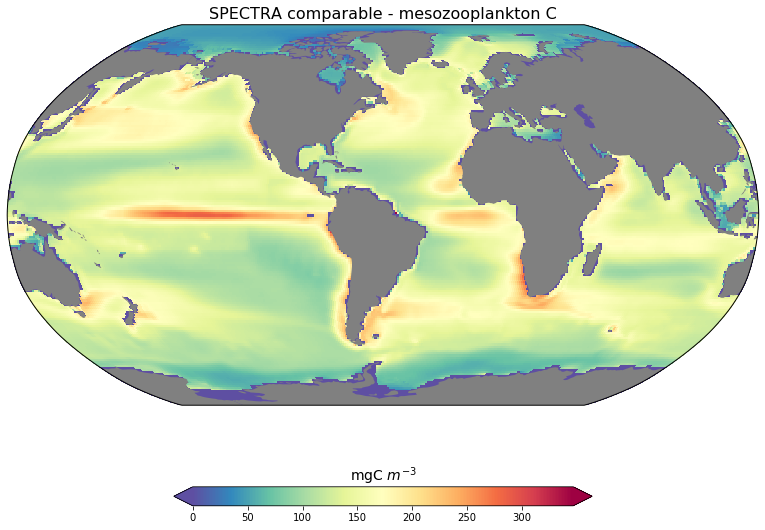

In [16]:
from cartopy.util import add_cyclic_point
fig = plt.figure(figsize=(15, 10))
lat = pp_ds.lat

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.nanmean(phytoC_regrid,axis=0), coord=pp_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('SPECTRA comparable - mesozooplankton C', fontsize =16)
cbar.ax.set_title('mgC $m^{-3}$', fontsize = 14)

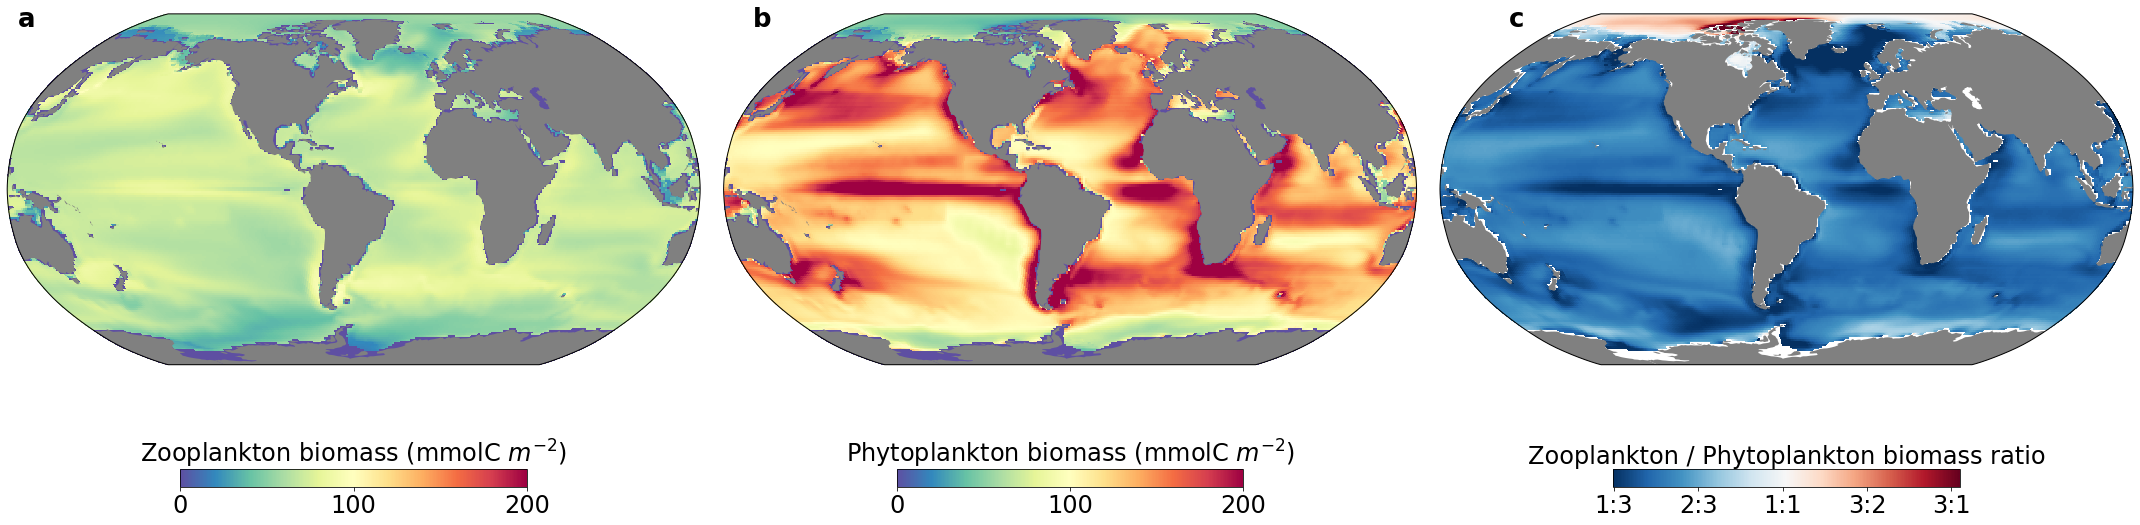

In [17]:
fig = plt.figure(figsize=(30, 10))

lat = pp_ds.lat
lev = np.arange(0, 201, 10)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=100)
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(np.nanmean(zooC_regrid,axis=0), coord=pp_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r', vmin = 0, vmax=200,transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.5, orientation='horizontal')
cb.ax.set_xticklabels(['0','100','200'])
cb.ax.set_title('Zooplankton biomass (mmolC $m^{-2}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)


ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.nanmean(phytoC_regrid,axis=0), coord=pp_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r', vmin = 0, vmax=200, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.5, orientation='horizontal')
cb.ax.set_xticklabels(['0','100','200'])
cb.ax.set_title('Phytoplankton biomass (mmolC $m^{-2}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)


lev = np.arange(0.33, 1.7, 0.05)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
ratio, lon = add_cyclic_point(np.nanmean(zooC_regrid,axis=0)/np.nanmean(phytoC_regrid,axis=0), coord=pp_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, ratio, cmap='RdBu_r',vmin = 0.33, vmax=1.7,  transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0.333,0.666,1,1.333,1.666],shrink=0.5, orientation='horizontal')
cb.ax.set_xticklabels(['1:3','2:3','1:1','3:2','3:1'])
cb.ax.set_title('Zooplankton / Phytoplankton biomass ratio', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/biomass_ZPratio_regrid_'+new_file+'.png',dpi=600, bbox_inches='tight')

## Import nutrient concentrations

In [18]:
no3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_NO3.*.nc', recursive=True))
no3_ds = xr.open_mfdataset(no3_inds,combine='by_coords')
po4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_PO4.*.nc', recursive=True))
po4_ds = xr.open_mfdataset(po4_inds,combine='by_coords')
sio3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_SiO3.*.nc', recursive=True))
sio3_ds = xr.open_mfdataset(sio3_inds,combine='by_coords')

In [19]:
ZP_ratio = np.nanmean(zooC_regrid,axis=0)/np.nanmean(phytoC_regrid,axis=0)

In [20]:
po4_ds.PO4

<xarray.DataArray 'PO4' (time: 12, z_t: 60, lat: 180, lon: 360)>
dask.array<concatenate, shape=(12, 60, 180, 360), dtype=float32, chunksize=(1, 60, 180, 360)>
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
Attributes:
    long_name:     Dissolved Inorganic Phosphate
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

Text(0, 0.5, '$log_{10}$(Z:P biomass ratio) ')

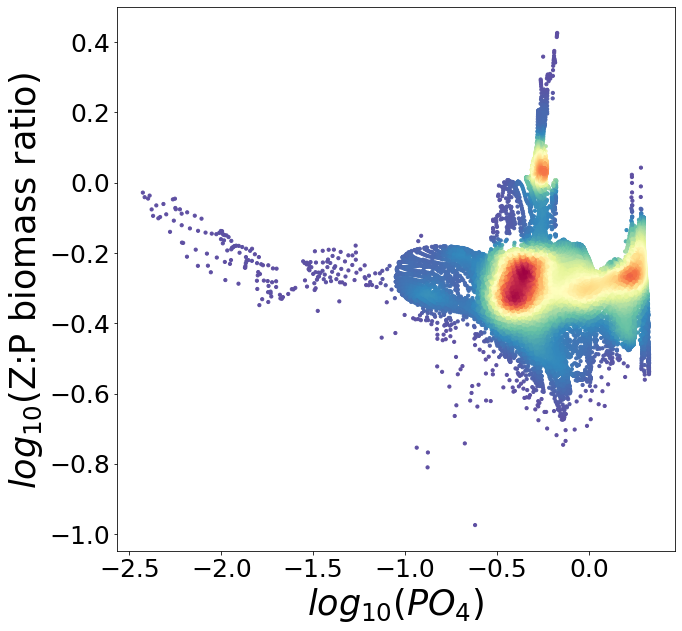

In [21]:
from scipy import stats
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
XX = po4_ds.PO4[:,0,:,:].mean(dim='time')
YY = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

xy = np.vstack([np.log10(X),np.log10(Y)])
z = gaussian_kde(xy)(xy)
plt.scatter(y=np.log10(Y),x=np.log10(X), c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$log_{10}$($PO_4$)', fontsize=35)
plt.ylabel('$log_{10}$(Z:P biomass ratio) ',fontsize = 35)
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Z_P_scatter_log_abundance'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

Text(0, 0.5, '$log_{10}$(Z:P biomass ratio) ')

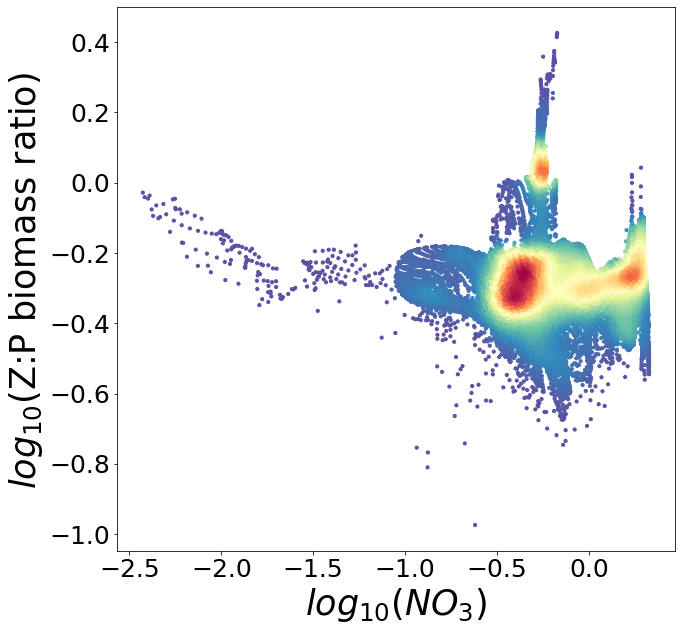

In [22]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
X = no3_ds.NO3[:,0,:,:].mean(dim='time')
Y = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

xy = np.vstack([np.log10(X),np.log10(Y)])
z = gaussian_kde(xy)(xy)
plt.scatter(y=np.log10(Y),x=np.log10(X), c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$log_{10}$($NO_3$)', fontsize=35)
plt.ylabel('$log_{10}$(Z:P biomass ratio) ',fontsize = 35)

Text(0, 0.5, '$log_{10}$(Z:P biomass ratio) ')

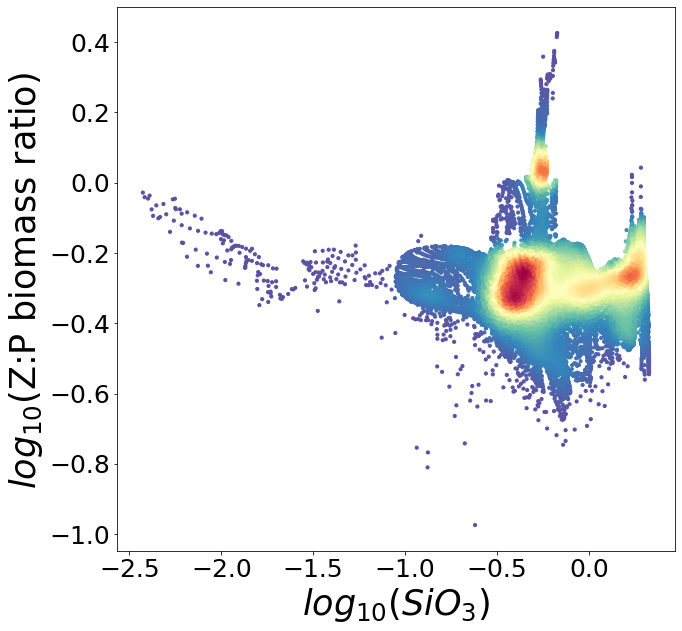

In [23]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
X = sio3_ds.SiO3[:,0,:,:].mean(dim='time')
Y = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

xy = np.vstack([np.log10(X),np.log10(Y)])
z = gaussian_kde(xy)(xy)
plt.scatter(y=np.log10(Y),x=np.log10(X), c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$log_{10}$($SiO_3$)', fontsize=35)
plt.ylabel('$log_{10}$(Z:P biomass ratio) ',fontsize = 35)

Text(0, 0.5, 'Z:P biomass ratio ')

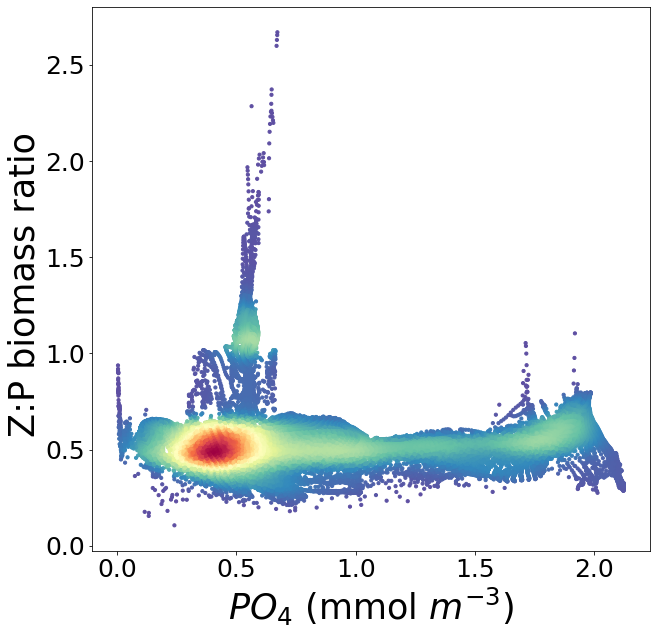

In [24]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
XX = po4_ds.PO4[:,0,:,:].mean(dim='time')
YY = ZP_ratio
X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

#plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$PO_4$ (mmol $m^{-3}$)', fontsize=35)
plt.ylabel('Z:P biomass ratio ',fontsize = 35)

Text(0, 0.5, 'Z:P biomass ratio ')

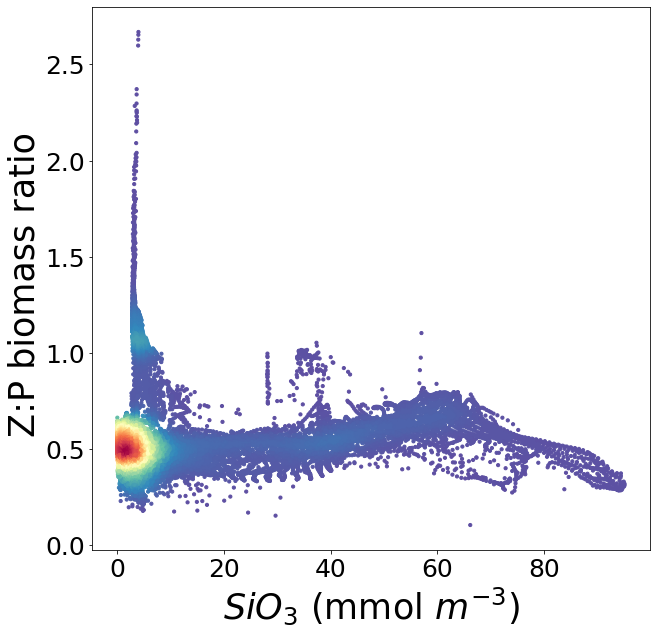

In [25]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
XX = sio3_ds.SiO3[:,0,:,:].mean(dim='time')
YY = ZP_ratio
X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

#plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$SiO_3$ (mmol $m^{-3}$)', fontsize=35)
plt.ylabel('Z:P biomass ratio ',fontsize = 35)

Text(0, 0.5, 'Z:P biomass ratio ')

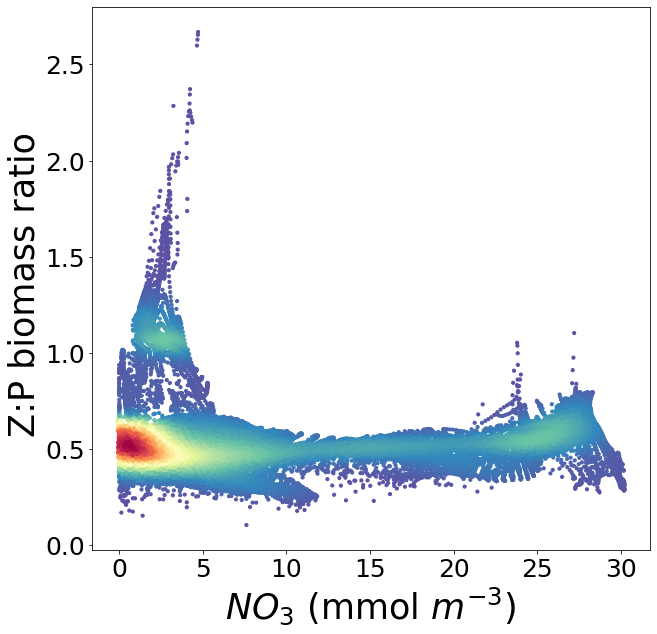

In [26]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
XX = no3_ds.NO3[:,0,:,:].mean(dim='time')
YY = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

#plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
    
#plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$NO_3$ (mmol $m^{-3}$)', fontsize=35)
plt.ylabel('Z:P biomass ratio ',fontsize = 35)

Text(0, 0.5, 'Z:P biomass ratio ')

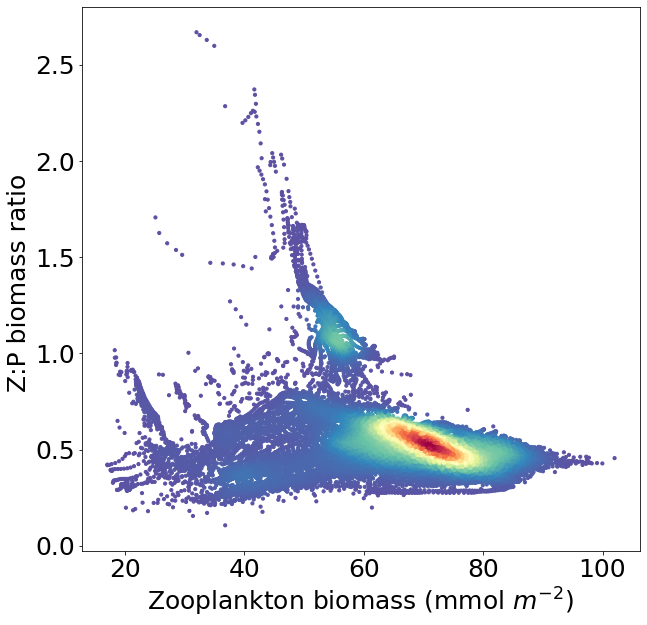

In [27]:
from scipy import stats
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

XX = np.nanmean(zooC_regrid,axis=0)
YY = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

#plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Zooplankton biomass (mmol $m^{-2}$)', fontsize=25)
plt.ylabel('Z:P biomass ratio ',fontsize = 25)

Text(0, 0.5, 'Z:P biomass ratio ')

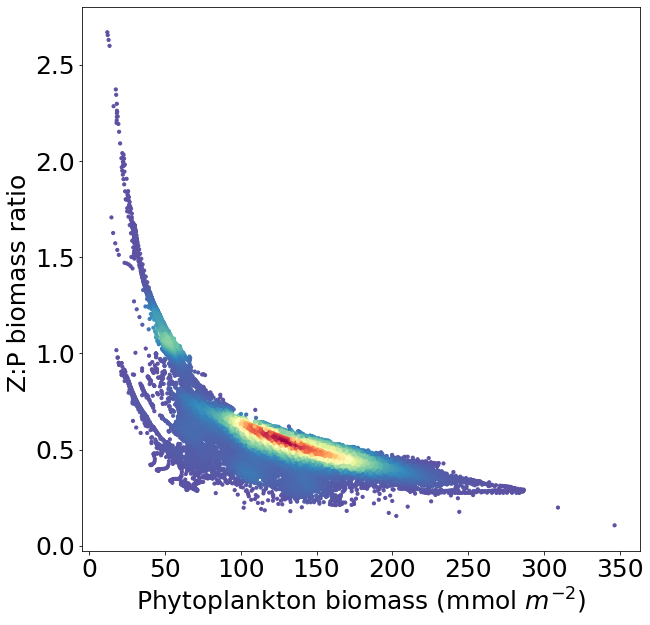

In [28]:
from scipy import stats
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

XX = np.nanmean(phytoC_regrid,axis=0)
YY = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

#plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Phytoplankton biomass (mmol $m^{-2}$)', fontsize=25)
plt.ylabel('Z:P biomass ratio ',fontsize = 25)

Text(0, 0.5, '$log_{10}$(Z:P biomass ratio) ')

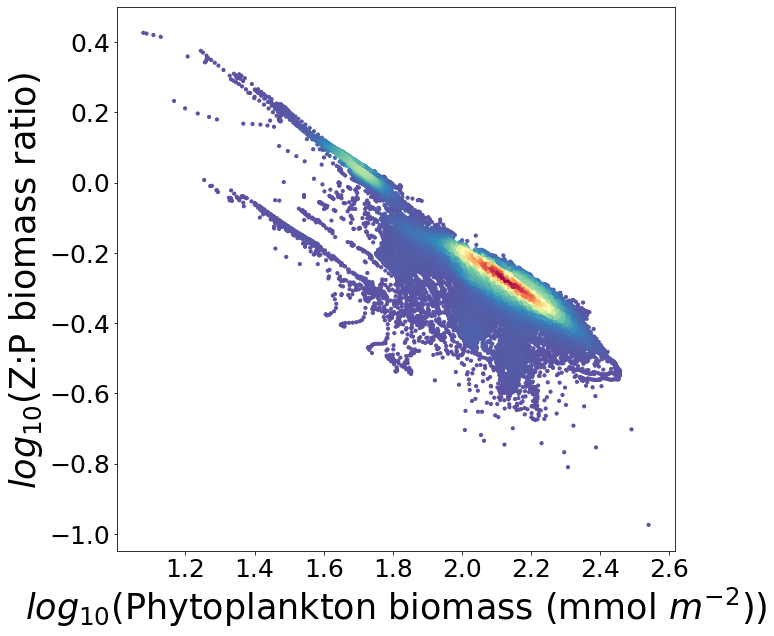

In [29]:
from scipy import stats
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
XX = np.nanmean(phytoC_regrid,axis=0)
YY = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

xy = np.vstack([np.log10(X),np.log10(Y)])
z = gaussian_kde(xy)(xy)
plt.scatter(y=np.log10(Y),x=np.log10(X), c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$log_{10}$(Phytoplankton biomass (mmol $m^{-2}$))', fontsize=35)
plt.ylabel('$log_{10}$(Z:P biomass ratio) ',fontsize = 35)

Text(0, 0.5, 'Z:P biomass ratio ')

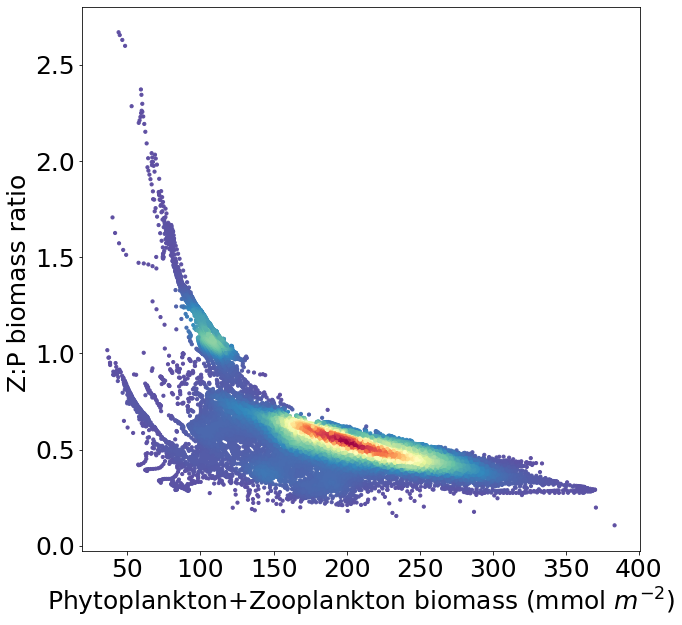

In [30]:
from scipy import stats
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

XX = np.nanmean(zooC_regrid,axis=0)+np.nanmean(phytoC_regrid,axis=0)
YY = ZP_ratio

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

#plt.scatter(y=Y,x=X, s=5, alpha=1,color='gray')
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Phytoplankton+Zooplankton biomass (mmol $m^{-2}$)', fontsize=25)
plt.ylabel('Z:P biomass ratio ',fontsize = 25)

## Compare with Biomes now

In [31]:
biome_mask = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_0104_0124.nc')
biome_mask_3D = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124.nc')
biome_mask = biome_mask.isel(time=0)
biome_mask.reset_coords('time', drop=True)

region_names = ['Eq-D','Eq-U','S-ST-PS','N-ST-PS','S-ST-SS','N-ST-SS','S-LL-U','N-LL-U','S-SP-SS','N-SP-SS','S-SIZ','N-SIZ']
region_NtoS_index = [11,9,5,3,7,1,0,6,2,4,8,10]
region_NtoS_names = [region_names[i] for i in region_NtoS_index]

biome_mask_x1 = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_0104_0124_remap.nc')
biome_mask_x04 = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_0104_0124_remap_x04.nc')

In [32]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [33]:
nt = len(ds.time.values)

rmask = np.zeros(shape=(nt,)+biome_mask.REGION_MASK.shape)
rmask3 = np.zeros(shape=(nt,)+biome_mask_3D.REGION_MASK_3D[0,:,:,:].shape)

rmask_val = biome_mask.REGION_MASK.values
rmask3_val = biome_mask_3D.REGION_MASK_3D.values

for i in range(nt):
    rmask[i,:,:]=rmask_val
    rmask3[i,:,:,:]=rmask3_val
    
biome_mask['rmask'] = xr.DataArray(rmask, coords={'time':range(nt), 'nlat':biome_mask.nlat.values, 'nlon':biome_mask.nlon.values}, dims=['time', 'nlat', 'nlon'])
biome_mask['rmask'].attrs=biome_mask['REGION_MASK'].attrs
biome_mask_3D['rmask3'] = xr.DataArray(rmask3, coords={'time':range(nt), 'region':biome_mask_3D.region.values, 'nlat':biome_mask_3D.nlat.values, 'nlon':biome_mask_3D.nlon.values}, dims=['time', 'region', 'nlat', 'nlon'])
biome_mask_3D['rmask3'].attrs=biome_mask_3D['REGION_MASK_3D'].attrs

biome_mask['REGION_MASK'] = biome_mask['rmask']
biome_mask_3D['REGION_MASK_3D'] = biome_mask_3D['rmask3']
biome_mask = biome_mask.drop(['rmask'])
biome_mask_3D = biome_mask_3D.drop(['rmask3'])

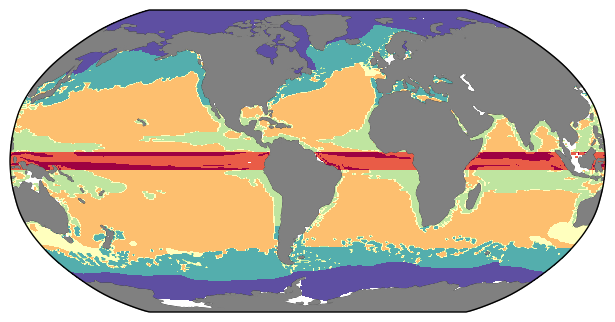

In [34]:
lon = biome_mask.TLONG.values
lat = biome_mask.TLAT.values
field = biome_mask.REGION_MASK[0,:,:].values
lon,lat,field = adjust_pop_grid(lon,lat,field)

fig = plt.figure(figsize=(10, 4),dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines()
ax.set_global()

land = ax.add_feature(
   cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                       edgecolor='face',
                                       facecolor='gray'))
cf = plt.contourf(lon,lat, field,cmap=discrete_cmap(7,'Spectral'), transform=ccrs.PlateCarree())

In [35]:
nbiome = len(biome_mask_3D.region.values)
nt = len(ds.time.values)
biome_means = np.zeros(shape=(nt,nbiome,2))

In [36]:
#X=phytoC.sum(dim='z_t_150m').mean(dim='time') *12.011
#Y=zooC.sum(dim='z_t_150m').mean(dim='time')*12.011
X = np.nanmean(phytoC_regrid,axis=0)
Y = np.nanmean(zooC_regrid,axis=0)

In [37]:
biome_mask_3D = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124_remap.nc')

In [38]:
region_N_SIZ = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[0]).values == 1)

In [39]:
# 'N_SIZ'
region_N_SIZ = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[0]).values == 1)
phyto_N_SIZ = np.log10(X)[region_N_SIZ] 
zoo_N_SIZ = np.log10(Y)[region_N_SIZ] 

# N_SP_SS
region_N_SP_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[1]).values == 1)
phyto_N_SP_SS = np.log10(X)[region_N_SP_SS] 
zoo_N_SP_SS = np.log10(Y)[region_N_SP_SS] 

# N_ST_SS
region_N_ST_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[2]).values == 1)
phyto_N_ST_SS = np.log10(X)[region_N_ST_SS]
zoo_N_ST_SS = np.log10(Y)[region_N_ST_SS] 

# N_ST_PS
region_N_ST_PS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[3]).values == 1)
phyto_N_ST_PS = np.log10(X)[region_N_ST_PS] 
zoo_N_ST_PS = np.log10(Y)[region_N_ST_PS] 

# N_LL_U
region_N_LL_U = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[4]).values == 1)
phyto_N_LL_U = np.log10(X)[region_N_LL_U] 
zoo_N_LL_U = np.log10(Y)[region_N_LL_U]

# Eq_U
region_Eq_U = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[5]).values == 1)
phyto_Eq_U = np.log10(X)[region_Eq_U] 
zoo_Eq_U = np.log10(Y)[region_Eq_U] 

# Eq_D
region_Eq_D = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[6]).values == 1)
phyto_Eq_D = np.log10(X)[region_Eq_D]
zoo_Eq_D = np.log10(Y)[region_Eq_D] 

# S_LL_U
region_S_LL_U = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[7]).values == 1)
phyto_S_LL_U = np.log10(X)[region_S_LL_U] 
zoo_S_LL_U = np.log10(Y)[region_S_LL_U] 

# S_ST_PS
region_S_ST_PS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[8]).values == 1)
phyto_S_ST_PS = np.log10(X)[region_S_ST_PS] 
zoo_S_ST_PS = np.log10(Y)[region_S_ST_PS] 

# S_ST_SS
region_S_ST_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[9]).values == 1)
phyto_S_ST_SS = np.log10(X)[region_S_ST_SS] 
zoo_S_ST_SS = np.log10(Y)[region_S_ST_SS] 


# S_SP_SS
region_S_SP_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[10]).values == 1)
phyto_S_SP_SS = np.log10(X)[region_S_SP_SS]
zoo_S_SP_SS = np.log10(Y)[region_S_SP_SS] 


# S_SIZ
region_S_SIZ = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[11]).values == 1)
phyto_S_SIZ = np.log10(X)[region_S_SIZ]
zoo_S_SIZ = np.log10(Y)[region_S_SIZ] 

Text(0, 0.5, 'log$_{10}$ Z:P biomass ratio ')

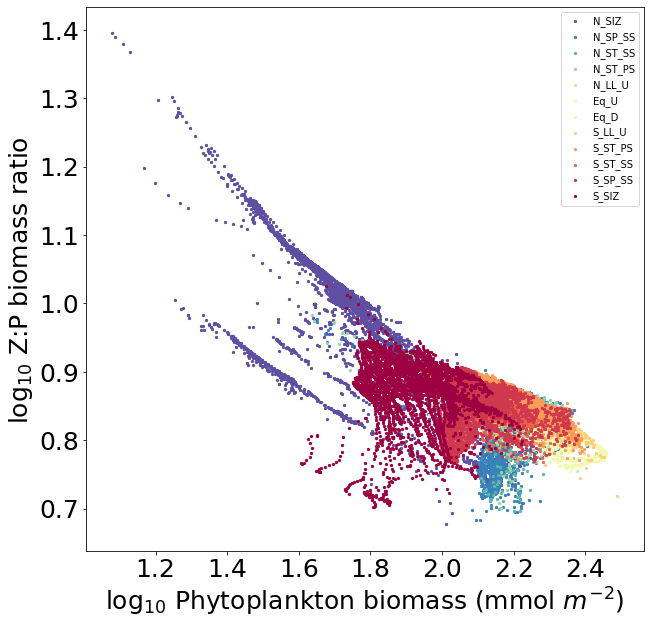

In [40]:
from scipy import stats
#fig, ax = plt.figure(figsize=(10, 10))
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
cmap=matplotlib.cm.get_cmap('Spectral_r', 12)
#plt.plot([1, 3], [1, 3], color='k', linestyle='--', linewidth=1)
plt.scatter(y=zoo_N_SIZ/phyto_N_SIZ,x=phyto_N_SIZ, s=5, alpha=1,color=cmap(0),label='N_SIZ')
plt.scatter(y=zoo_N_SP_SS/phyto_N_SP_SS,x=phyto_N_SP_SS, s=5, alpha=1,color=cmap(1),label='N_SP_SS')
plt.scatter(y=zoo_N_ST_SS/phyto_N_ST_SS,x=phyto_N_ST_SS, s=5, alpha=1,color=cmap(2),label='N_ST_SS')
plt.scatter(y=zoo_N_ST_PS/phyto_N_ST_PS,x=phyto_N_ST_PS, s=5, alpha=1,color=cmap(3),label='N_ST_PS')
plt.scatter(y=zoo_N_LL_U/phyto_N_LL_U,x=phyto_N_LL_U, s=5, alpha=1,color=cmap(4),label='N_LL_U')
plt.scatter(y=zoo_Eq_U/phyto_Eq_U,x=phyto_Eq_U, s=5, alpha=1,color=cmap(5),label='Eq_U')
plt.scatter(y=zoo_Eq_D/phyto_Eq_D,x=phyto_Eq_D, s=5, alpha=1,color=cmap(6),label='Eq_D')
plt.scatter(y=zoo_S_LL_U/phyto_S_LL_U,x=phyto_S_LL_U, s=5, alpha=1,color=cmap(7),label='S_LL_U')
plt.scatter(y=zoo_S_ST_PS/phyto_S_ST_PS,x=phyto_S_ST_PS, s=5, alpha=1,color=cmap(8),label='S_ST_PS')
plt.scatter(y=zoo_S_ST_SS/phyto_S_ST_SS,x=phyto_S_ST_SS, s=5, alpha=1,color=cmap(9),label='S_ST_SS')
plt.scatter(y=zoo_S_SP_SS/phyto_S_SP_SS,x=phyto_S_SP_SS, s=5, alpha=1,color=cmap(10),label='S_SP_SS')
plt.scatter(y=zoo_S_SIZ/phyto_S_SIZ,x=phyto_S_SIZ, s=5, alpha=1,color=cmap(11),label='S_SIZ')
#ax.axis([1, 3, 1, 3])

pylab.legend(loc='outside')  
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton biomass (mmol $m^{-2}$)', fontsize=25)
plt.ylabel('log$_{10}$ Z:P biomass ratio ',fontsize = 25)
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Z_P_scatter_log_biome'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

In [41]:
# 'N_SIZ'
region_N_SIZ = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[0]).values == 1)
phyto_N_SIZ = X[region_N_SIZ] 
zoo_N_SIZ = Y[region_N_SIZ] 

# N_SP_SS
region_N_SP_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[1]).values == 1)
phyto_N_SP_SS = X[region_N_SP_SS] 
zoo_N_SP_SS = Y[region_N_SP_SS] 

# N_ST_SS
region_N_ST_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[2]).values == 1)
phyto_N_ST_SS = X[region_N_ST_SS]
zoo_N_ST_SS = Y[region_N_ST_SS] 

# N_ST_PS
region_N_ST_PS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[3]).values == 1)
phyto_N_ST_PS = X[region_N_ST_PS] 
zoo_N_ST_PS = Y[region_N_ST_PS] 

# N_LL_U
region_N_LL_U = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[4]).values == 1)
phyto_N_LL_U = X[region_N_LL_U] 
zoo_N_LL_U = Y[region_N_LL_U]

# Eq_U
region_Eq_U = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[5]).values == 1)
phyto_Eq_U = X[region_Eq_U] 
zoo_Eq_U = Y[region_Eq_U] 

# Eq_D
region_Eq_D = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[6]).values == 1)
phyto_Eq_D = X[region_Eq_D]
zoo_Eq_D = Y[region_Eq_D] 

# S_LL_U
region_S_LL_U = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[7]).values == 1)
phyto_S_LL_U = X[region_S_LL_U] 
zoo_S_LL_U = Y[region_S_LL_U] 

# S_ST_PS
region_S_ST_PS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[8]).values == 1)
phyto_S_ST_PS = X[region_S_ST_PS] 
zoo_S_ST_PS = Y[region_S_ST_PS] 

# S_ST_SS
region_S_ST_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[9]).values == 1)
phyto_S_ST_SS = X[region_S_ST_SS] 
zoo_S_ST_SS = Y[region_S_ST_SS] 


# S_SP_SS
region_S_SP_SS = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[10]).values == 1)
phyto_S_SP_SS = X[region_S_SP_SS]
zoo_S_SP_SS = Y[region_S_SP_SS] 


# S_SIZ
region_S_SIZ = np.where(biome_mask_3D.REGION_MASK_3D.isel(time=0, region=region_NtoS_index[11]).values == 1)
phyto_S_SIZ = X[region_S_SIZ]
zoo_S_SIZ = Y[region_S_SIZ] 

Text(0, 0.5, 'Z:P biomass ratio ')

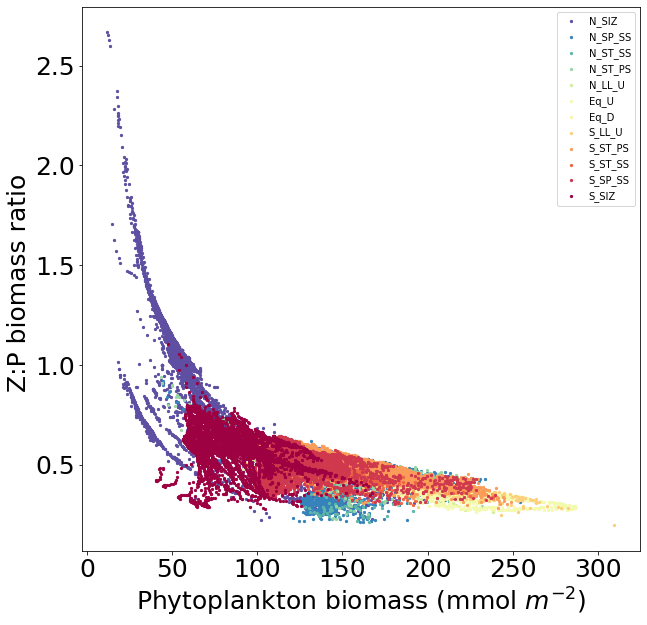

In [42]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
cmap=matplotlib.cm.get_cmap('Spectral_r', 12)

plt.scatter(y=zoo_N_SIZ/phyto_N_SIZ,x=phyto_N_SIZ, s=5, alpha=1,color=cmap(0),label='N_SIZ')
plt.scatter(y=zoo_N_SP_SS/phyto_N_SP_SS,x=phyto_N_SP_SS, s=5, alpha=1,color=cmap(1),label='N_SP_SS')
plt.scatter(y=zoo_N_ST_SS/phyto_N_ST_SS,x=phyto_N_ST_SS, s=5, alpha=1,color=cmap(2),label='N_ST_SS')
plt.scatter(y=zoo_N_ST_PS/phyto_N_ST_PS,x=phyto_N_ST_PS, s=5, alpha=1,color=cmap(3),label='N_ST_PS')
plt.scatter(y=zoo_N_LL_U/phyto_N_LL_U,x=phyto_N_LL_U, s=5, alpha=1,color=cmap(4),label='N_LL_U')
plt.scatter(y=zoo_Eq_U/phyto_Eq_U,x=phyto_Eq_U, s=5, alpha=1,color=cmap(5),label='Eq_U')
plt.scatter(y=zoo_Eq_D/phyto_Eq_D,x=phyto_Eq_D, s=5, alpha=1,color=cmap(6),label='Eq_D')
plt.scatter(y=zoo_S_LL_U/phyto_S_LL_U,x=phyto_S_LL_U, s=5, alpha=1,color=cmap(7),label='S_LL_U')
plt.scatter(y=zoo_S_ST_PS/phyto_S_ST_PS,x=phyto_S_ST_PS, s=5, alpha=1,color=cmap(8),label='S_ST_PS')
plt.scatter(y=zoo_S_ST_SS/phyto_S_ST_SS,x=phyto_S_ST_SS, s=5, alpha=1,color=cmap(9),label='S_ST_SS')
plt.scatter(y=zoo_S_SP_SS/phyto_S_SP_SS,x=phyto_S_SP_SS, s=5, alpha=1,color=cmap(10),label='S_SP_SS')
plt.scatter(y=zoo_S_SIZ/phyto_S_SIZ,x=phyto_S_SIZ, s=5, alpha=1,color=cmap(11),label='S_SIZ')
#ax.axis([1, 3, 1, 3])

pylab.legend(loc='outside')  
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Phytoplankton biomass (mmol $m^{-2}$)', fontsize=25)
plt.ylabel('Z:P biomass ratio ',fontsize = 25)